In [8]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

from pa_lib.job import request_job
from pa_lib.file import project_dir, load_bin, load_csv
from pa_lib.data import desc_col
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np
from pa_lib.vis import boxplot_histogram

import seaborn as sns

import urlopen

sns.set_style("darkgrid")

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"
import plotly.express as px

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os

C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython\stc
C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython


In [43]:
BASELINE_DATE = pd.to_datetime("13.01.2020",format="%d.%m.%Y")

# Load data

In [9]:
DATA_DIR = Path.home() / "data" / "dashboard-corona"

In [10]:
DATA_DIR

WindowsPath('C:/Users/stc/data/dashboard-corona')

In [52]:
apple_df = pd.read_feather(DATA_DIR / "apple_mobility_data.feather")
zh_hardbruecke_df = pd.read_feather(DATA_DIR / "hardbruecke_data.feather")
zh_fussvelo_df = pd.read_feather(DATA_DIR / "passanten_velo_sum.feather")
zh_auto_df = pd.read_feather(DATA_DIR / "verkehrsdaten_median.feather")


In [110]:
container_df = apple_df.loc[
    apple_df.region.isin(["Zurich"]),
    ["date","transportation_type", "percent"]
].rename(columns={
    "percent": "apple_percent",
    "transportation_type": "type"}
        ).eval("apple_percent = apple_percent - 100")


In [111]:
zh_transit_df = zh_hardbruecke_df.loc[:,["Date", "Trend"]].rename(
    columns={"Date": "date","Trend": "zh_percent"})
zh_transit_df.loc[:,"type"] = "transit"

In [112]:
zh_walking_df = zh_fussvelo_df.loc[:,["date","trend"]].rename(
    columns={"trend": "zh_percent"}
)
zh_walking_df.loc[:,"type"] = "walking"

In [113]:
auto_baseline_value = (zh_auto_df.loc[
    zh_auto_df.date == BASELINE_DATE,
    "AnzFahrzeuge"].values[0]
                      )
zh_auto_series = ((zh_auto_df.AnzFahrzeuge - auto_baseline_value)
                  / auto_baseline_value *100)

zh_driving_df = pd.DataFrame({"date": zh_auto_df.date, "zh_percent": zh_auto_series, "type": "driving"})

In [114]:
zh_fusion_df = pd.concat([zh_transit_df,zh_walking_df, zh_driving_df]).astype({"date": "datetime64[ns]"})

In [115]:
combination_df = pd.merge(container_df, zh_fusion_df, left_on=["date","type"],right_on=["date","type"],how="left")

In [116]:
combination_df.loc[combination_df.zh_percent.isna()]


,date,type,apple_percent,zh_percent
95,2020-02-13,walking,3.48,NaN
98,2020-02-14,walking,21.96,NaN
101,2020-02-15,walking,26.49,NaN
104,2020-02-16,walking,-14.32,NaN
107,2020-02-17,walking,-2.37,NaN


In [117]:
combination_df.sample(200)

,date,type,apple_percent,zh_percent
38,2020-01-25,walking,30.85,-23.273480
10,2020-01-16,transit,-2.13,6.388701
168,2020-03-09,driving,-2.64,2.964427
302,2020-04-22,walking,-27.65,-17.795808
15,2020-01-18,driving,9.67,-7.114625
...,...,...,...,...
334,2020-05-03,transit,-56.00,-62.221469
322,2020-04-29,transit,-56.69,-52.813559
247,2020-04-04,transit,-72.46,-68.248588
136,2020-02-27,transit,5.23,6.314124


# Correlation

In [118]:
combination_df.groupby("type").corr(method="pearson")

apple_percent  zh_percent
type                                            
driving apple_percent       1.000000    0.764985
        zh_percent          0.764985    1.000000
transit apple_percent       1.000000    0.903659
        zh_percent          0.903659    1.000000
walking apple_percent       1.000000    0.754416
        zh_percent          0.754416    1.000000

In [120]:
combination_df.shape

(357, 4)

In [121]:
combination_df.corr(method="pearson")

,apple_percent,zh_percent
apple_percent,1.000000,0.834269
zh_percent,0.834269,1.000000


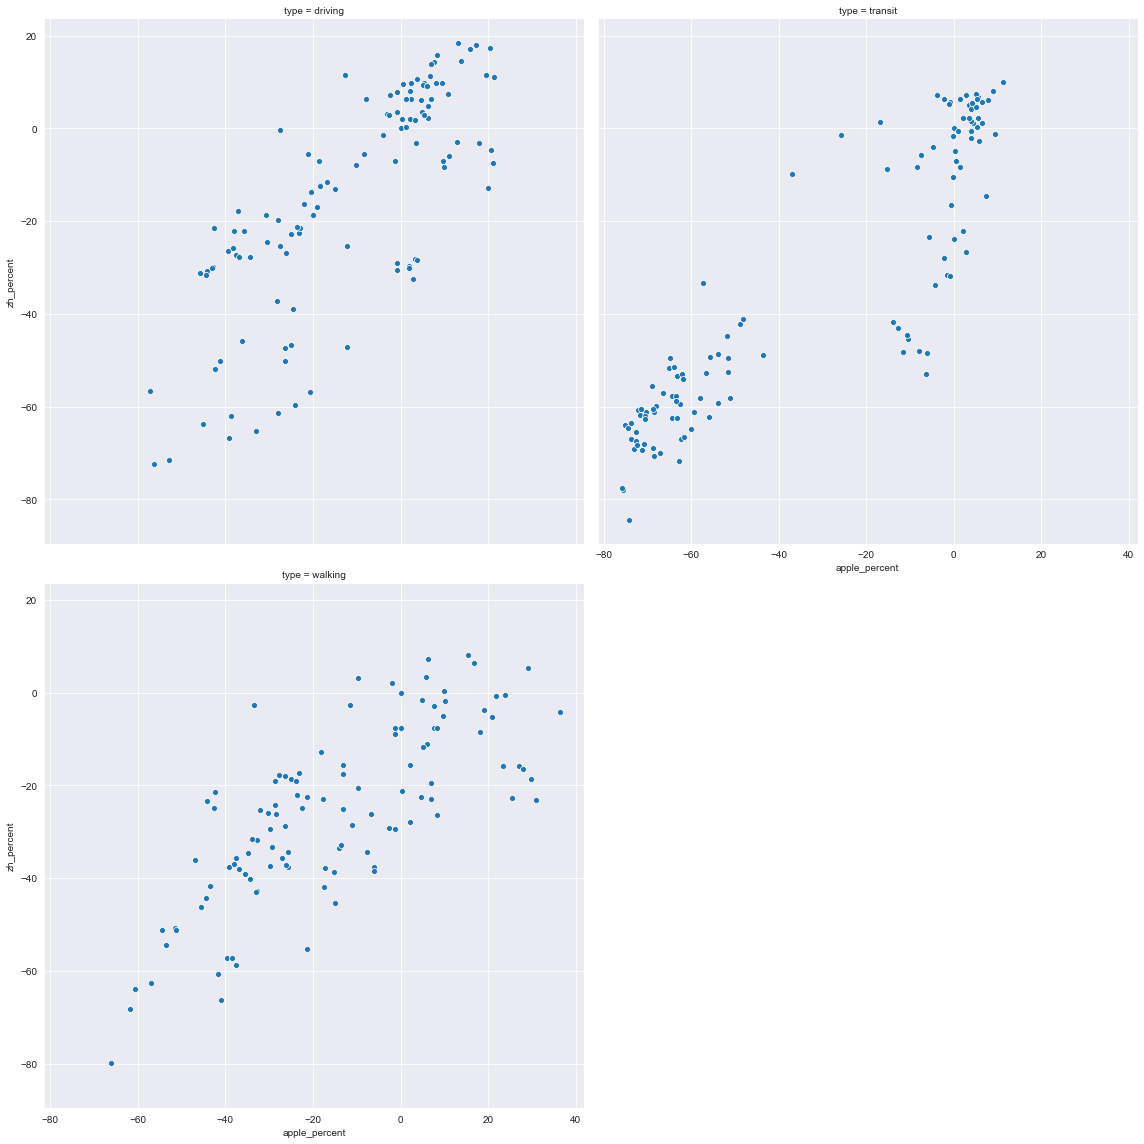

In [122]:
sns.relplot(x="apple_percent",y="zh_percent", col="type", data=combination_df,col_wrap=2,height=8)

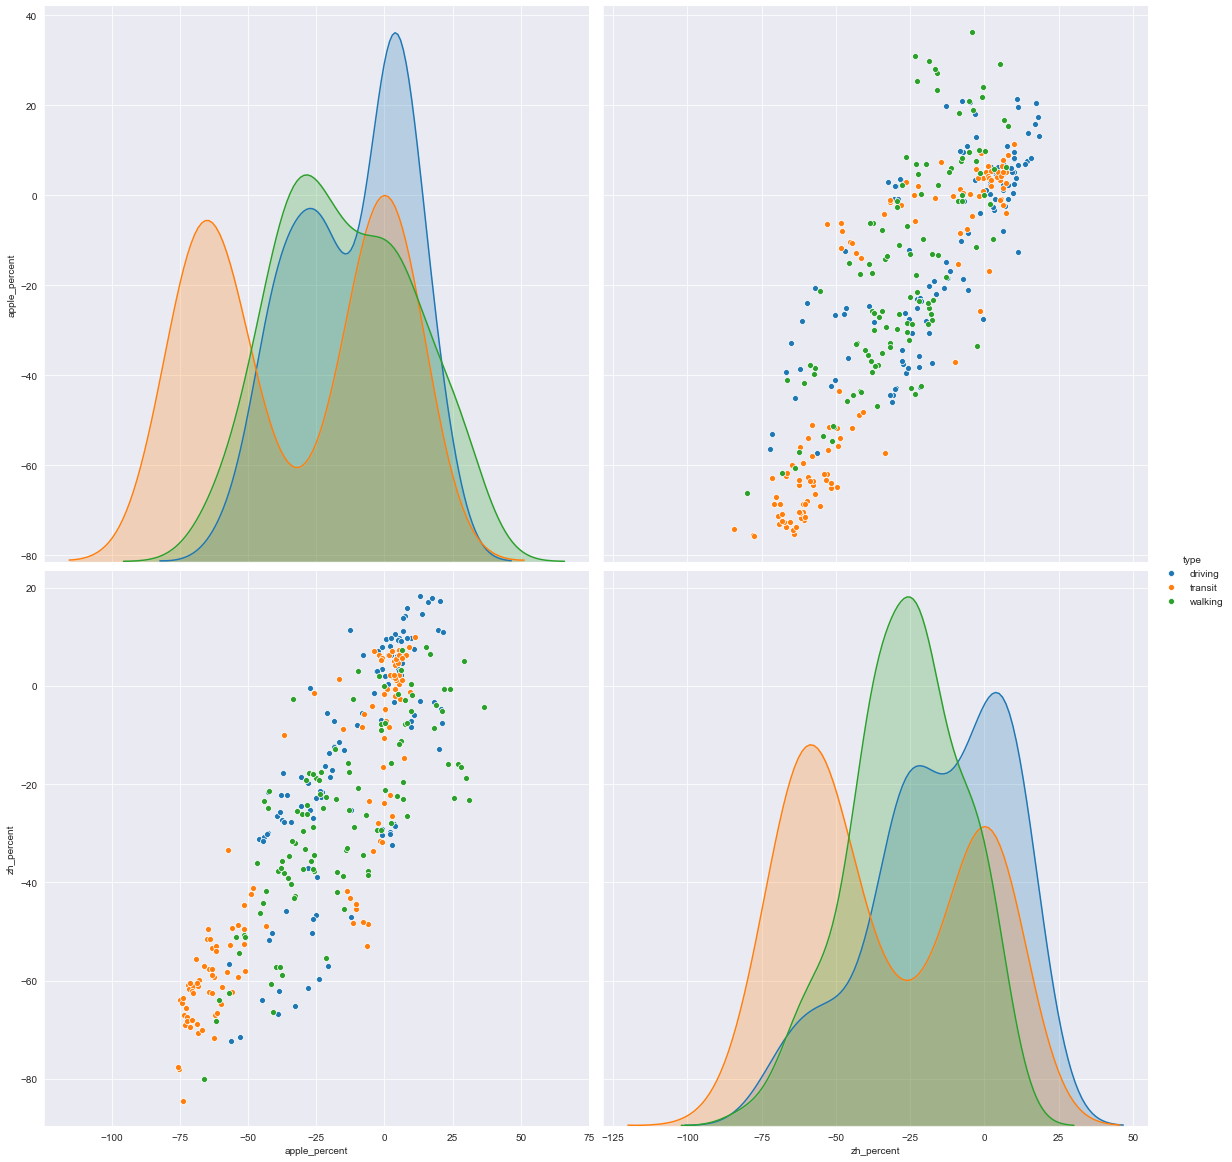

In [123]:
sns.pairplot(combination_df,hue="type",height=8)